In [2]:
import ctypes
libgcc_s = ctypes.CDLL('libgcc_s.so.1')
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/avic/OOD_Orientation_Generalization')
from my_dataclasses import *
from train.dataset import *
from train.train import *
from numpy.random import choice
import tools
import seaborn as sns
from pandas.api.types import CategoricalDtype
import itertools
import functools
from sklearn.preprocessing import normalize
from matplotlib_venn import *

In [ ]:
ExpData.get_experiments(319).training_category

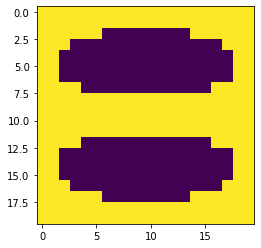

In [151]:
analytical_heatmap = np.load('canonical_z_unrestricted_heatmap.npy')

fig8 = np.mean((np.power(analytical_heatmap[0], 10) * 3) + (np.power(analytical_heatmap[1], 20) * 1), axis=2) > 0.5
# plt.close('all')
# plt.imshow(np.mean(np.power(analytical_heatmap[0], 10) * 3, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(np.mean(np.power(analytical_heatmap[1], 20) * 1, axis=2), norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
# plt.imshow(fig8, norm=plt.Normalize(vmin=0, vmax=1))
# plt.show()
plt.imshow(fig8)

xs, ys, zs = tools.get_heatmap_cell_ranges2(20)

cubelet_ranges = np.array(list(itertools.product(np.stack([xs[:-1], xs[1:]]).T, np.stack([ys[:-1], ys[1:]]).T))).reshape(20, 20, 2, 2)

fig8_ranges = cubelet_ranges[~fig8]

In [166]:
all_data = None
for x in range(4):
    e = ExpData.get_experiments(x)

    image_activations = np.load(e.image_activations)

    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes

    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)

    df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_hole'] = in_hole

    norm_image_activations = image_activations / np.max(image_activations, axis=0)

    THRESHOLD = 0.2

    pre_transformed_activations = np.zeros((50, 512))
    for name, group in df[df.in_bin].groupby('model_name'):
        pre_transformed_activations[group.model_code.iloc[0]] = np.mean(norm_image_activations[group.index], axis=0)

    pre_transformed_activations_per_image = pre_transformed_activations[df.model_code]

    image_invariances = 1 - np.abs((norm_image_activations - pre_transformed_activations_per_image) / (norm_image_activations + pre_transformed_activations_per_image))

    image_invariances_thresholded = np.where((norm_image_activations > THRESHOLD) | (pre_transformed_activations_per_image > THRESHOLD), image_invariances, np.nan)

    full_bin_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.training_models) & df.in_bin)]
    partial_bin_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.testing_models) & df.in_bin)]
    
    full_8_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.training_models) & ~df.in_hole & ~df.in_bin)]
    partial_8_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.testing_models) & ~df.in_hole & ~df.in_bin)]

    full_hole_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.training_models) & df.in_hole & ~df.in_bin)]
    partial_hole_invariances = image_invariances_thresholded[np.where(df.model_name.isin(rd.testing_models) & df.in_hole & ~df.in_bin)]

    iterables = [range(512), ['full', 'partial']]
    data = pd.DataFrame(index=pd.MultiIndex.from_product(iterables, names=["neuron", "model_type"]), columns=['bin', 'fig8', 'hole'])
    data.bin = np.vstack(np.array([np.nanmean(full_bin_invariances, axis=0), np.nanmean(partial_bin_invariances, axis=0)])).T.flatten()
    data.fig8 = np.vstack(np.array([np.nanmean(full_8_invariances, axis=0), np.nanmean(partial_8_invariances, axis=0)])).T.flatten()
    data.hole = np.vstack(np.array([np.nanmean(full_hole_invariances, axis=0), np.nanmean(partial_hole_invariances, axis=0)])).T.flatten()

    melted_data = data.melt(value_vars=['bin', 'fig8', 'hole'], var_name='pattern', value_name='invariance', ignore_index=False).reset_index()
    melted_data['#seen'] = e.data_div
    if all_data is None:
        all_data = melted_data
    else:
        all_data = all_data.append(melted_data)
    print(f'done {x}')

/home/avic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


done 0
done 1
done 2
done 3


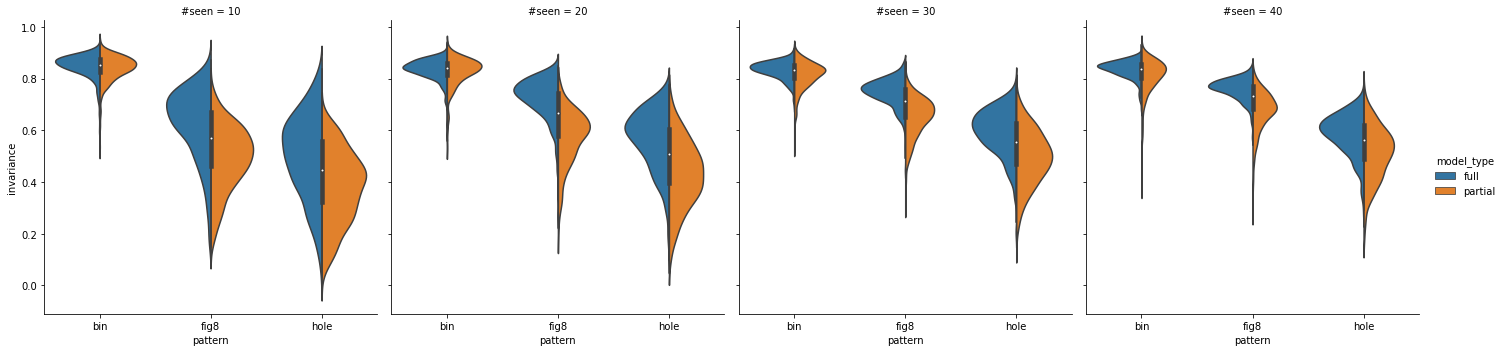

In [ ]:
sns.catplot(kind='violin', data=all_data, col='#seen', x='pattern', y='invariance', split=True, hue='model_type', )

In [3]:
e = ExpData.get_experiments(3)

In [6]:
np.mean(np.load(e.eval_heatmap_id), axis=2)

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [ ]:
def fs(x):
    return set(np.argwhere(x).flatten())

e = ExpData.get_experiments(3)
image_activations = np.load(e.image_activations)
rd = RotationDataset(e)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
norm_image_activations = image_activations / np.max(image_activations, axis=0)
in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
df['in_hole'] = in_hole

neural_cat_activations = np.zeros((3, 50, 512))
for name, group in df.groupby('model_name'):
    neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
    neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
    neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

neural_cat_activations = neural_cat_activations.reshape(150, 512)
norm_activity = neural_cat_activations / np.max(neural_cat_activations, axis=0)

selectivity = norm_activity > 0.8
selectivity = selectivity.reshape(3, 50, 512)

f = np.any(selectivity[:,:40], axis=1)
r = np.any(selectivity[:,40:], axis=1)

fb, f8, fh = [x for x in f]
rb, r8, rh = [x for x in r]

In [ ]:
combs = []
for x in range(1, 16):
    b_rep = bin(x)[2:]
    combs.append([int(y) for y in '0' * (4 - len(b_rep)) + b_rep])
combs = np.array(combs, dtype=bool)

In [91]:
groups = np.array([fb, rb, f8, r8])
labels = ['fb', 'rb', 'f8', 'r8']

In [99]:
headers = []
for comb in combs:
    header = []
    for i, c in enumerate(comb):
        if c:
            header.append(labels[i])
    headers.append(', '.join(header))

In [89]:
venn_intersections = ~(np.expand_dims(groups, 0) ^ np.expand_dims(combs, 2))

In [101]:
counts = np.sum(np.all(venn_intersections, axis=1), axis=1)

In [113]:
ratios = np.round((counts * 100) / np.sum(counts), 2)

In [114]:
pd.DataFrame({'count': counts, 'ratio': ratios}, index=headers)

,count,ratio
r8,0,0.00
f8,37,7.27
"f8, r8",10,1.96
rb,12,2.36
"rb, r8",0,0.00
"rb, f8",6,1.18
"rb, f8, r8",1,0.20
fb,158,31.04
"fb, r8",1,0.20
"fb, f8",145,28.49


In [107]:
pd.DataFrame({k:v for k, v in zip(headers, counts)}, index=[0])

,r8,f8,"f8, r8",rb,"rb, r8","rb, f8","rb, f8, r8",fb,"fb, r8","fb, f8","fb, f8, r8","fb, rb","fb, rb, r8","fb, rb, f8","fb, rb, f8, r8"
0,0,37,10,12,0,6,1,158,1,145,14,79,0,40,6


In [119]:
def fs(x):
    return set(np.argwhere(x).flatten())

results = []

for x in range(4):
    e = ExpData.get_experiments(x)
    image_activations = np.load(e.image_activations)
    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_hole'] = in_hole
    
    fc_weights = torch.load(e.checkpoint, map_location=torch.device('cpu'))['fc.weight'].detach().cpu().numpy()

    neural_cat_activations = np.zeros((3, 50, 512))
    for name, group in df.groupby('model_name'):
        neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
        neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
        neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

    # neural_cat_activations = np.expand_dims(fc_weights, 0) * neural_cat_activations
    neural_cat_activations = neural_cat_activations.reshape(150, 512)
    norm_activity = neural_cat_activations / np.max(neural_cat_activations, axis=0)

    selectivity = norm_activity > 0.8
    selectivity = selectivity.reshape(3, 50, 512)

    f = np.any(selectivity[:,:40], axis=1)
    r = np.any(selectivity[:,40:], axis=1)

    fb, f8, fh = f
    rb, r8, rh = r

    b = fs(f[0] | r[0])
    fig8 = fs(f[1] | r[1])
    h = fs(f[2] | r[2])

    results.append({'fb':fb, 'f8':f8, 'fh':fh, 'rb':rb, 'r8':r8, 'rh':rh, 'b':b, 'fig8':fig8, 'h':h})

In [120]:
diagrams = [
    (['fb', 'rb', 'f8', 'r8']),
    (['fb', 'rb', 'fh', 'rh']),
]

In [136]:
counts = np.zeros((4, 15))
ratios = np.zeros((4, 15))
for x in range(4):
    groups = np.array([results[x][g] for g in diagrams[0]])
    labels = diagrams[0]
    venn_intersections = ~(np.expand_dims(groups, 0) ^ np.expand_dims(combs, 2))
    counts[x] = np.sum(np.all(venn_intersections, axis=1), axis=1)
    ratios[x] = np.round((counts[x] * 100) / np.sum(counts[x]), 2)

In [139]:
counts

array([[  0.,  13.,   4.,  13.,   0.,   8.,   3., 273.,   0.,  29.,   9.,
        145.,   0.,  10.,   4.],
       [  1.,  22.,  10.,  21.,   0.,   2.,   0., 210.,   2.,  86.,  16.,
        104.,   0.,  27.,   5.],
       [  0.,  25.,   2.,  12.,   0.,   4.,   2., 193.,   0., 120.,  19.,
         73.,   0.,  50.,  10.],
       [  0.,  37.,  10.,  12.,   0.,   6.,   1., 158.,   1., 145.,  14.,
         79.,   0.,  40.,   6.]])

In [140]:
counts.T.flatten()

array([  0.,   1.,   0.,   0.,  13.,  22.,  25.,  37.,   4.,  10.,   2.,
        10.,  13.,  21.,  12.,  12.,   0.,   0.,   0.,   0.,   8.,   2.,
         4.,   6.,   3.,   0.,   2.,   1., 273., 210., 193., 158.,   0.,
         2.,   0.,   1.,  29.,  86., 120., 145.,   9.,  16.,  19.,  14.,
       145., 104.,  73.,  79.,   0.,   0.,   0.,   0.,  10.,  27.,  50.,
        40.,   4.,   5.,  10.,   6.])

In [127]:
nested_dicts = [{f'counts #{(d + 1) * 10}': counts[d], f'ratios #{(d + 1) * 10}': ratios[d]} for d in range(4)]
flattened_dicts = {k: v for d in nested_dicts for k, v in d.items()}

In [129]:
idx = pd.MultiIndex.from_product([headers,
                                  [(x + 1) * 10 for x in range(4)]],
                                 names=['group', '# seen'])

In [141]:
pd.DataFrame({'counts': counts.T.flatten(), 'ratios': ratios.T.flatten()}, index=idx, columns=['counts', 'ratios'])

counts  ratios
group          # seen                
r8             10         0.0    0.00
               20         1.0    0.20
               30         0.0    0.00
               40         0.0    0.00
f8             10        13.0    2.54
               20        22.0    4.35
               30        25.0    4.90
               40        37.0    7.27
f8, r8         10         4.0    0.78
               20        10.0    1.98
               30         2.0    0.39
               40        10.0    1.96
rb             10        13.0    2.54
               20        21.0    4.15
               30        12.0    2.35
               40        12.0    2.36
rb, r8         10         0.0    0.00
               20         0.0    0.00
               30         0.0    0.00
               40         0.0    0.00
rb, f8         10         8.0    1.57
               20         2.0    0.40
               30         4.0    0.78
               40         6.0    1.18
rb, f8, r8     10         3.0    0.59
               20         0.0    0.00
               30         2.0    0.39
               40         1.0    0.20
fb             10       273.0   53.42
               20       210.0   41.50
               30       193.0   37.84
               40       158.0   31.04
fb, r8         10         0.0    0.00
               20         2.0    0.40
               30         0.0    0.00
               40         1.0    0.20
fb, f8         10        29.0    5.68
               20        86.0   17.00
               30       120.0   23.53
               40       145.0   28.49
fb, f8, r8     10         9.0    1.76
               20        16.0    3.16
               30        19.0    3.73
               40        14.0    2.75
fb, rb         10       145.0   28.38
               20       104.0   20.55
               30        73.0   14.31
               40        79.0   15.52
fb, rb, r8     10         0.0    0.00
               20         0.0    0.00
               30         0.0    0.00
               40         0.0    0.00
fb, rb, f8     10        10.0    1.96
               20        27.0    5.34
               30        50.0    9.80
               40        40.0    7.86
fb, rb, f8, r8 10         4.0    0.78
               20         5.0    0.99
               30        10.0    1.96
               40         6.0    1.18

In [6]:
diagrams = [
    (['fb', 'f8', 'fh'], 'fully seen venn'),
    (['rb', 'r8', 'rh'], 'restricted seen venn'),
    (['b', 'f8', 'r8'], 'bin fig8 crossover'),
    (['b', 'fh', 'rh'], 'bin fig8 crossover'),
]
def set_venn_scale(ax, true_area, reference_area=300):
    s = np.sqrt(float(reference_area)/true_area)
    ax.set_xlim(-s, s)
    ax.set_ylim(-s, s)

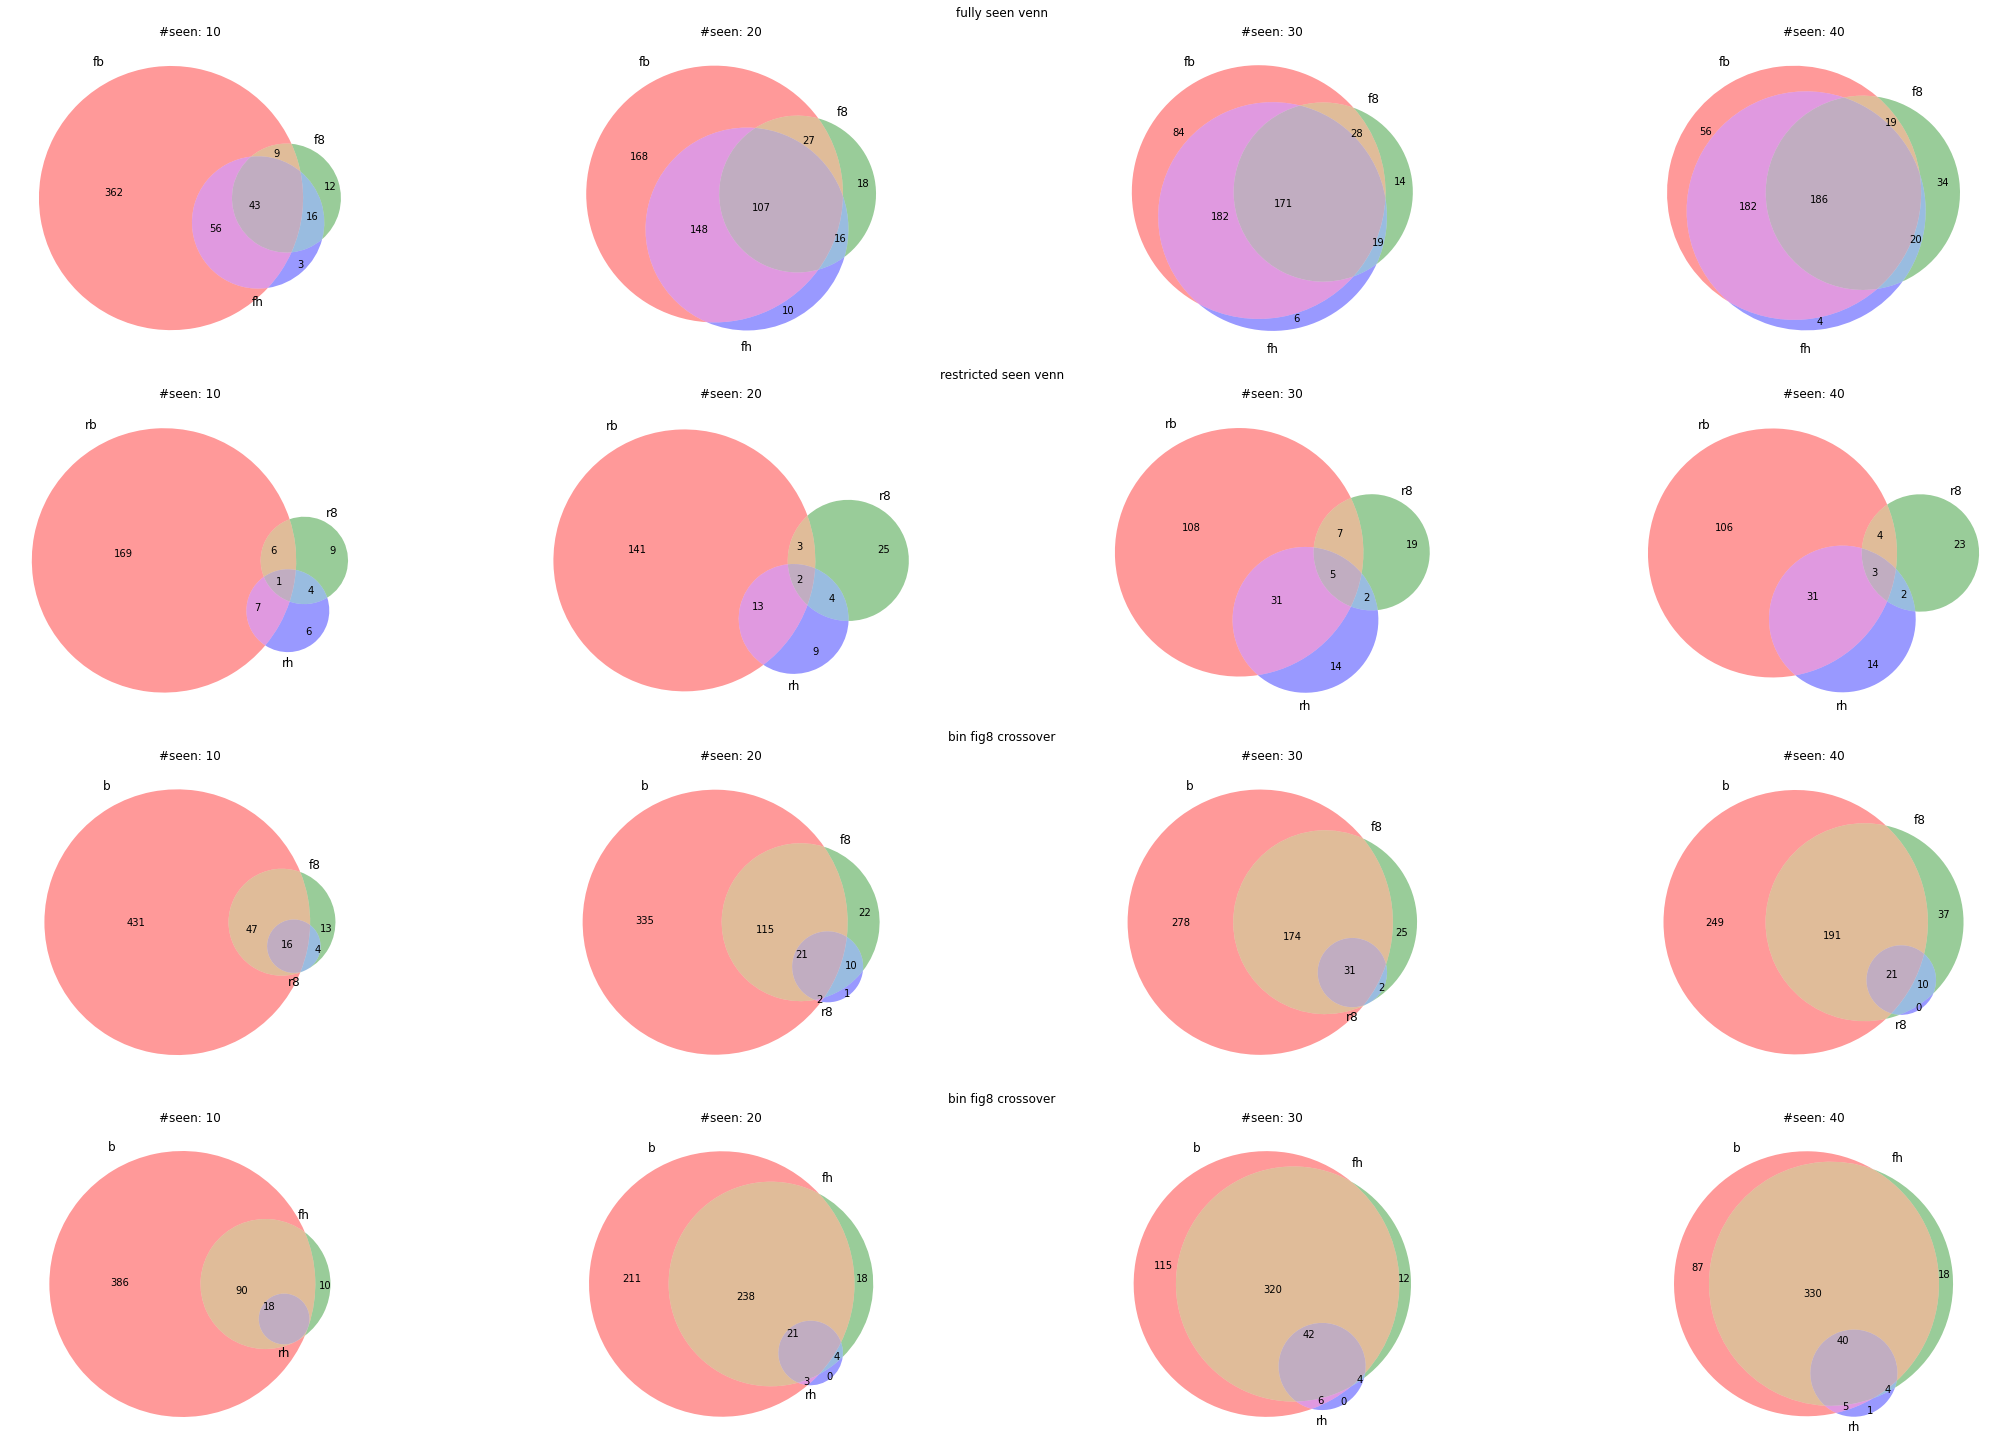

In [8]:
plt.close('all')

fig = plt.figure(constrained_layout=True, figsize=(30, 20))

subfigs = fig.subfigures(nrows=len(diagrams), ncols=1)
for subfig, diagram in zip(subfigs, diagrams):
    subfig.suptitle(diagram[1])

    axes = subfig.subplots(1, 4)

    for x in range(4):
        venn3([results[x][g] for g in diagram[0]], set_labels=[g for g in diagram[0]], ax=axes[x])
        axes[x].set(title=f'#seen: {(x + 1) * 10}')
        # from matplotlib_venn._venn3 import compute_venn3_subsets
        # set_venn_scale(axes[x], sum(compute_venn3_subsets(*[results[x][g] for g in diagrams[0][0]])))

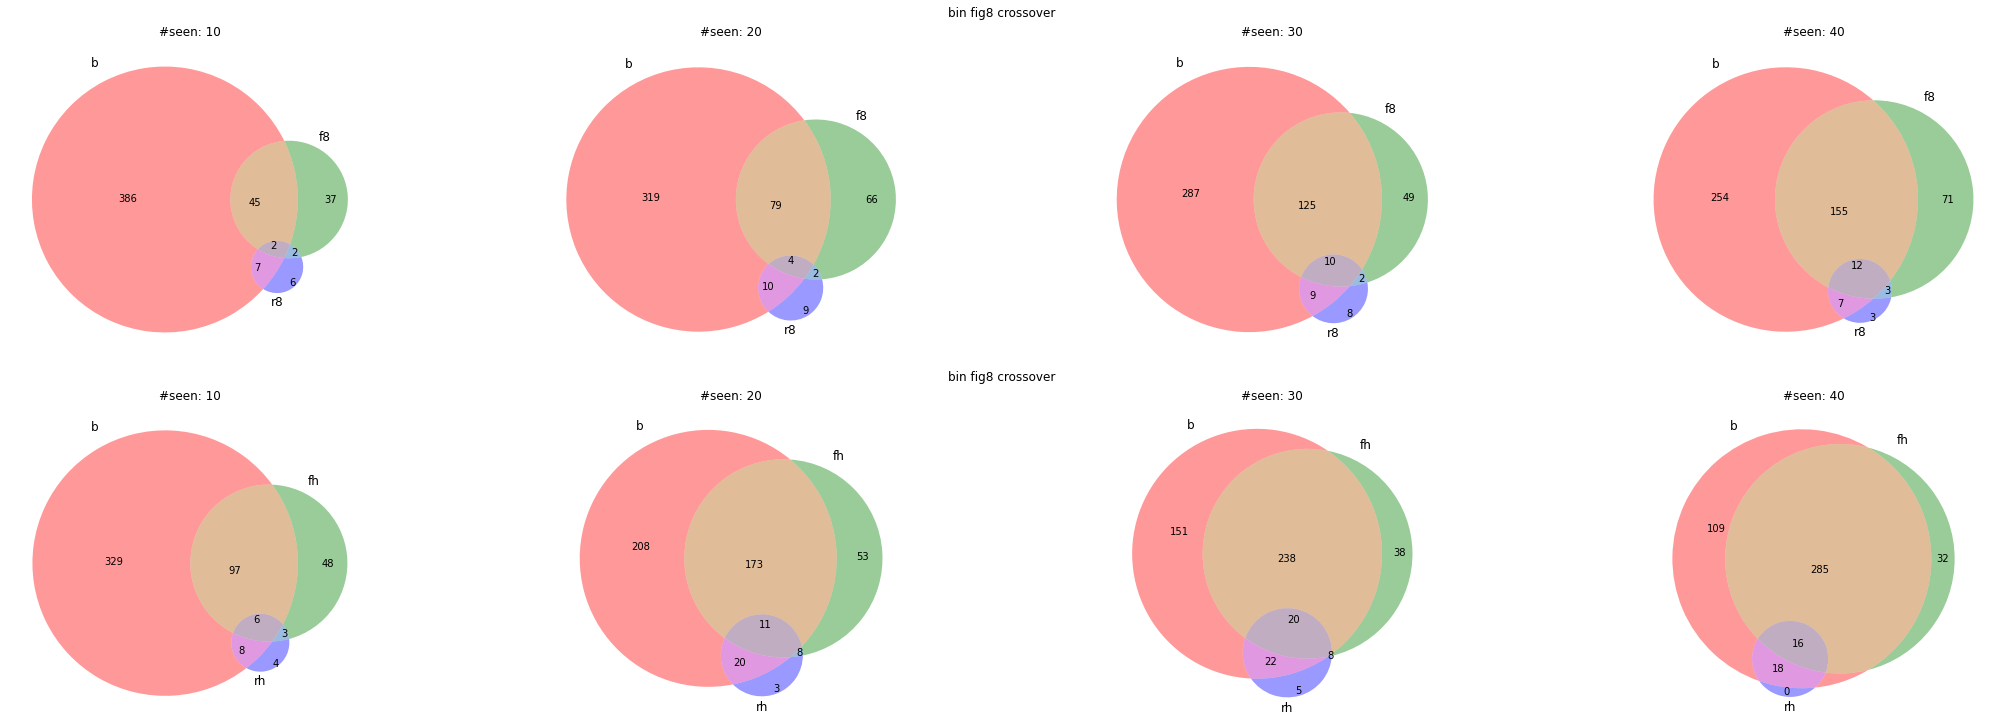

In [13]:
plt.close('all')

fig = plt.figure(constrained_layout=True, figsize=(30, 10))

subfigs = fig.subfigures(nrows=len(diagrams), ncols=1)
for subfig, diagram in zip(subfigs, diagrams):
    subfig.suptitle(diagram[1])

    axes = subfig.subplots(1, 4)

    for x in range(4):
        venn3([results[x][g] for g in diagram[0]], set_labels=[g for g in diagram[0]], ax=axes[x])
        axes[x].set(title=f'#seen: {(x + 1) * 10}')
        # from matplotlib_venn._venn3 import compute_venn3_subsets
        # set_venn_scale(axes[x], sum(compute_venn3_subsets(*[results[x][g] for g in diagrams[0][0]])))

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('restricted seen venn')
for x in range(4):
    res = results[x]
    venn3([res['rb'], res['r8'], res['rh']], set_labels=['r_bin', 'r_fig8', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')
    
for a, d in zip(flatten(axes), range(4)):
    print(sum(compute_venn3_subsets(*[results[d][g] for g in diagrams[1][0]])))
    set_venn_scale(a, sum(compute_venn3_subsets(*[results[d][g] for g in diagrams[1][0]])))
    
plt.show()

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('restricted seen venn')
for x in range(4):
    res = results[x]
    venn3([res['rb'], res['r8'], res['rh']], set_labels=['r_bin', 'r_fig8', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')
    
for a, d in zip(flatten(axes), range(4)):
    set_venn_scale(a, sum(compute_venn3_subsets(*[results[d][g] for g in diagrams[0][0]])))
    
plt.show()

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin crossover')
for x in range(4):
    res = results[x]
    venn2([res['fb'], res['rb']], set_labels=['f_bin', 'r_bin'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('8 crossover')
for x in range(4):
    res = results[x]
    venn2([res['f8'], res['r8']], set_labels=['f_fig8', 'r_fig8'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('hole crossover')
for x in range(4):
    res = results[x]
    venn2([res['fh'], res['rh']], set_labels=['f_hole', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin fig8 crossover')
for x in range(4):
    res = results[x]
    venn3([res['b'], res['f8'], res['r8']], set_labels=['f+r_bin', 'f_fig8', 'r_fig8'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig.suptitle('bin hole crossover')
for x in range(4):
    res = results[x]
    venn3([res['b'], res['fh'], res['rh']], set_labels=['f+r_bin', 'f_hole', 'r_hole'], ax=axes[x])
    axes[x].set(title=f'#seen: {(x + 1) * 10}')

In [ ]:
all_data = None
for x in range(4):
    e = ExpData.get_experiments(x)
    image_activations = np.load(e.image_activations)
    rd = RotationDataset(e)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['model_code'] = df.model_name.astype(CategoricalDtype(categories=df.model_name.unique(),ordered=True)).cat.codes
    norm_image_activations = image_activations / np.max(image_activations, axis=0)
    in_hole = functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), fig8_ranges, df.object_x > 10)
    df['in_bin'] = df.object_x.between(-0.25, 0.25) & df.object_y.between(-0.25, 0.25)
    df['in_hole'] = in_hole

    neural_cat_activations = np.zeros((3, 50, 512))
    for name, group in df.groupby('model_name'):
        neural_cat_activations[0, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[group.in_bin].index], axis=0)
        neural_cat_activations[1, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & ~group.in_hole].index], axis=0)
        neural_cat_activations[2, group.model_code.iloc[0]] = np.mean(norm_image_activations[group[~group.in_bin & group.in_hole].index], axis=0)

    norm_activity = normalize(neural_cat_activations.reshape(150, 512), axis=0, norm='l1')

    selectivity = np.zeros((150, 512))
    for y in range(512):
        a = norm_activity[:, y]
        b = np.argsort(a)[::-1]
        c = np.add.accumulate(a[b]) < 0.2
        selectivity[b[c], y] = 1
    
    selectivity = selectivity.reshape(3, 50, 512)

    f = np.any(selectivity[:,:40], axis=1)
    r = np.any(selectivity[:,:40], axis=1)

    fb = f[0]
    f8 = f[1]
    fh = f[2]

    rb = r[0]
    r8 = r[1]
    rh = r[2]

    data = pd.DataFrame({
        'bf': fb & ~f8 & ~fh & ~rb & ~r8 & ~rh,
        '8f': ~fb & f8 & ~fh & ~rb & ~r8 & ~rh,
        'hf': ~fb & ~f8 & fh & ~rb & ~r8 & ~rh,
        'b8f': fb & f8 & ~fh & ~rb & ~r8 & ~rh,
        'bhf': fb & ~f8 & fh & ~rb & ~r8 & ~rh,
        'b8hf': fb & f8 & fh & ~rb & ~r8 & ~rh,
        'br': ~fb & ~f8 & ~fh & rb & ~r8 & ~rh,
        '8r': ~fb & ~f8 & ~fh & ~rb & r8 & ~rh,
        'hr': ~fb & ~f8 & ~fh & ~rb & ~r8 & rh,
        'b8r': ~fb & ~f8 & ~fh & rb & r8 & ~rh,
        'bhr': ~fb & ~f8 & ~fh & rb & ~r8 & rh,
        'b8hr': ~fb & ~f8 & ~fh & rb & r8 & rh,
        'bfr': fb & ~f8 & ~fh & rb & ~r8 & ~rh,
        '8fr': ~fb & f8 & ~fh & ~rb & r8 & ~rh,
        'hfr': ~fb & ~f8 & fh & ~rb & ~r8 & rh,
        'b8fr': fb & f8 & ~fh & rb & r8 & ~rh,
        'bhfr': fb & ~f8 & fh & rb & ~r8 & rh,
        'bh8fr': fb & f8 & fh & rb & r8 & rh,
    })
    
    melted_data = data.melt()
    melted_data = melted_data[melted_data.value]
    
    melted_data['#seen'] = e.data_div
    if all_data is None:
        all_data = melted_data
    else:
        all_data = all_data.append(melted_data)
    print(f'done {x}')

In [ ]:
sns.catplot(kind='count', col='#seen', x='variable', data=all_data, col_wrap=2)